In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
file = open("data_adasyn_risk2","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [3]:
X_train.head(2)

,menopaus_0,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,agegrp_10,...,race_5,hispanic_0,hispanic_1,bmi_3,bmi_4,agefirst_1,agefirst_2,nrelbc_0,nrelbc_2,lastmamm_1
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [4]:
X_train.shape

(218866, 25)

In [5]:
X_test.shape

(59501, 25)

# Model Building on Cancer Data

## <span style="color:blue">Model 3 - XGBoost</span>

### Default Hyperparameters

Let's first fit a random forest model with default hyperparameters.

In [6]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi = TP / float(TP+FN)
    speci = TN / float(TN+FP)
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)

    print("Average:", (sensi+speci)/2)

    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    
    # Predicting probability for roc_auc
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

!pip install xgboost

In [7]:
# Importing random forest classifier from sklearn library
from xgboost import XGBClassifier

In [8]:
xgb = XGBClassifier(random_state = 100)

# fit
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train_def = xgb.predict(X_train) # For train data
y_pred_test_def = xgb.predict(X_test) # For test data

#### Evaluating model on balanced train data with default parameters

Confusion Matrix ->
[[79117 30419]
 [23158 86172]]
Accuracy: 0.755206381987152
Sensitivity: 0.7881825665416629
Specificity: 0.7222922144317849
Average: 0.7552373904867239
Precision 0.7390964997298247
MCC  0.5115700922485177
F1  0.7628507310077416
F2  0.7778505933263646
F3  0.782982497108293
ROC-AUC : 0.84


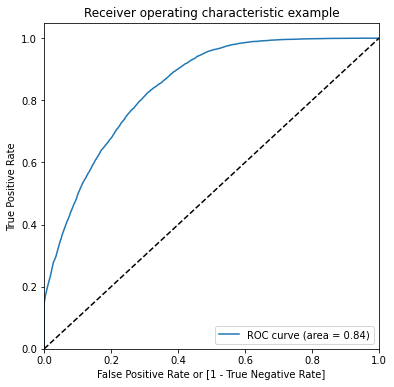

In [10]:
# For train
model_stats(X_train, y_train, y_pred_train_def, xgb)

#### Evaluating model on imbalanced test data with default parameters

Confusion Matrix ->
[[37781 20149]
 [  517  1054]]
Accuracy: 0.6526781062503151
Sensitivity: 0.6709102482495226
Specificity: 0.6521836699464871
Average: 0.6615469590980049
Precision 0.04970994670565486
MCC  0.10816379983154938
F1  0.09256169315886537
F2  0.1917269982173391
F3  0.2982287363476883
ROC-AUC : 0.71


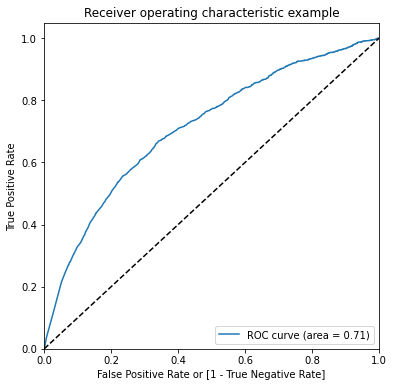

In [11]:
# For test
model_stats(X_test, y_test, y_pred_test_def, xgb)

In [12]:
# We can now find the optimal hyperparameters using GridSearchCV.
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

### Hyperparameter Tuning : Grid Search to Find Optimal Hyperparameters

We can now use GridSearchCV to find multiple optimal hyperparameters together.

The following hyperparameters are present in a random forest classifier. Note that most of these hypereparameters are actually of the decision trees that are in the forest.
- **max_depth** : integer or None, optional (default=None)The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **min_samples_leaf** : int, float, optional (default=1)The minimum number of samples required to be at a leaf node:**
- **min_samples_split** : int, float, optional (default=2)The minimum number of samples required to split an internal node:**
- **n_estimators**: integer, optional (default=10): The number of trees in the forest.
- **criterion**: string, optional (default=”gini”)The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific.
- **max_features** : int, float, string or None, optional (default=”auto”)The number of features to consider when looking for the best split:

In [13]:
# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [150,250,300]
}

xgb = XGBClassifier(
 learning_rate =0.2,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print(grid_search.cv_results_)
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  8.1min finished


{'mean_fit_time': array([ 96.12708087, 155.63689914, 116.79625077]), 'std_fit_time': array([ 2.40496739,  7.47483224, 46.86130142]), 'mean_score_time': array([0.67313051, 0.67841821, 0.40951891]), 'std_score_time': array([0.05822379, 0.18005842, 0.01852844]), 'param_n_estimators': masked_array(data=[150, 250, 300],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 150}, {'n_estimators': 250}, {'n_estimators': 300}], 'split0_test_score': array([0.75518604, 0.76034719, 0.76140594]), 'split1_test_score': array([0.75968408, 0.76496513, 0.76544409]), 'split2_test_score': array([0.75132747, 0.75712909, 0.75793122]), 'split3_test_score': array([0.7569705 , 0.76032087, 0.76094657]), 'split4_test_score': array([0.75788122, 0.76171872, 0.7626989 ]), 'mean_test_score': array([0.75620986, 0.7608962 , 0.76168534]), 'std_test_score': array([0.00284001, 0.00253204, 0.00244429]), 'rank_test_score': array([3, 2, 1])}
best accuracy 0.7

we choose n_estimators as 100

# Create the parameter grid based on the results of random search 
param_grid = {
   # 'max_depth': [5,7,9],
    'min_child_weight' : [3,5,7]
}

xgb = XGBClassifier(
 learning_rate =0.2,
 n_estimators=100,
 gamma=0,
 max_depth=6,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

xgb.fit(X_train,y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print(grid_search.cv_results_)
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

In [15]:
scores = grid_search.cv_results_
pd.DataFrame(scores).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,298.755374,1.406975,2.034031,0.211716,1,{'min_child_weight': 1},0.736160,0.735842,0.734866,0.735629,...,0.736235,0.001293,2,0.737643,0.736430,0.735174,0.735183,0.737514,0.736389,0.001074
1,296.808828,2.719066,2.165481,0.169101,3,{'min_child_weight': 3},0.735588,0.734454,0.737886,0.736698,...,0.736649,0.001508,1,0.737071,0.734844,0.737332,0.736617,0.737146,0.736602,0.000910
2,295.002163,1.757993,2.026129,0.396733,5,{'min_child_weight': 5},0.734987,0.734918,0.735810,0.736305,...,0.736096,0.001291,4,0.736431,0.735576,0.735715,0.736170,0.737318,0.736242,0.000620
3,296.129280,1.641658,1.905926,0.445899,7,{'min_child_weight': 7},0.735725,0.735623,0.735649,0.737137,...,0.736136,0.000606,3,0.737376,0.736500,0.735443,0.736817,0.735307,0.736289,0.000798


In [14]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5,7,8]
}

xgb = XGBClassifier(
 learning_rate =0.2,
 n_estimators=300,
 gamma=0,
 min_child_weight=3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

xgb.fit(X_train,y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.9min finished


best accuracy 0.7632164460935495
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [15]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'gamma': [0,.1,.2,.3,.4,.5]
}

xgb = XGBClassifier(
 learning_rate =0.2,
 n_estimators=300,
 min_child_weight=3,
 max_depth=8,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 17.1min finished


best accuracy 0.7634100778720694
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [16]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb = XGBClassifier(
 learning_rate =0.2,
 n_estimators=300,
 max_depth=8,
 min_child_weight=3, 
 objective= 'binary:logistic',
 nthread=4,
 gamma=0.1,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 45.8min finished


best accuracy 0.7634853966909771
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [17]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'reg_alpha':[0.001, 0.005, 0.01, 0.05]
}

xgb = XGBClassifier(
 learning_rate =0.2,
 n_estimators=300,
 max_depth=8,
 min_child_weight=3,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid,  scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 11.1min finished


best accuracy 0.7636475490922455
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [18]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'reg_lambda':[0.5,0.6,0.7,0.8,0.9]
}

xgb = XGBClassifier(
 learning_rate =0.2,
 n_estimators=300,
 max_depth=8,
 min_child_weight=3,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.9,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid,  scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 14.6min finished


best accuracy 0.7637884011003034
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.01, reg_lambda=0.5,
              scale_pos_weight=1, seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [19]:
xgb = XGBClassifier(
 learning_rate =0.2,
 n_estimators=300,
 max_depth=8,
 min_child_weight=3,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 reg_alpha=0.01,
 reg_lambda=0.5,
 seed=27)


# Fit the grid search to the data
xgb.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.01, reg_lambda=0.5,
              scale_pos_weight=1, seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

Confusion Matrix ->
[[75042 34494]
 [16871 92459]]
Accuracy: 0.7653130225800261
Sensitivity: 0.8456873685173328
Specificity: 0.685089833479404
Average: 0.7653886009983684
Precision 0.7282931478578687
MCC  0.537712854412001
F1  0.7826123758374492
F2  0.819275421648741
F3  0.8322719036332851
ROC-AUC : 0.85


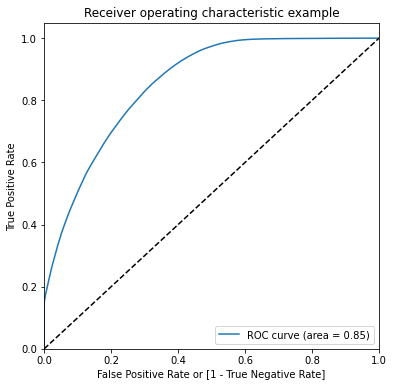

In [20]:
#### Model evaluation on train data

# Predicting on test dataframe using predict
y_pred_train = xgb.predict(X_train)
model_stats(X_train, y_train, y_pred_train, xgb)

Confusion Matrix ->
[[35645 22285]
 [  488  1083]]
Accuracy: 0.6172669366901397
Sensitivity: 0.6893698281349459
Specificity: 0.6153115829449335
Average: 0.6523407055399397
Precision 0.04634542964738103
MCC  0.10002833330344969
F1  0.08685191868158305
F2  0.18261837312828813
F3  0.2887461007278641
ROC-AUC : 0.71


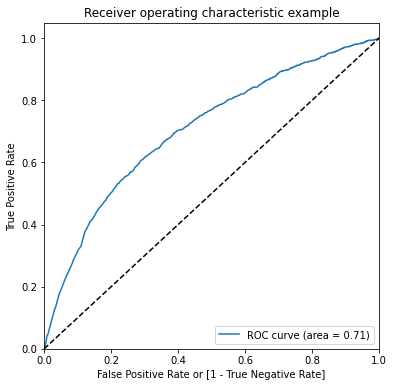

In [21]:
#### Model evaluation on test data

# Predicting on test dataframe using predict

y_pred_test = xgb.predict(X_test)
#y_pred_test=(xgb.predict_proba(X_test)[:,1] > 0.51).astype(bool)

model_stats(X_test, y_test, y_pred_test, xgb)